In [1]:
# Load Libraries

import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

The next couple cells compute the spectrogram of the song you load

In [2]:
filename = r"C:\Song.wav"
# filename = livetune feat. Hatsune Miku - Hand in Hand (Instrumental) (online-audio-converter.com)
y, sr = librosa.load(filename)
song, _ = librosa.effects.trim(y)
n_fft = 16384
print(len(librosa.fft_frequencies(sr=sr, n_fft=n_fft)))

8193


In [3]:
hop_length = 512
D = np.abs(librosa.stft(song, n_fft=n_fft, hop_length=hop_length))
print(D.shape)

(8193, 13272)


In [4]:
print(D.max(), D.min())

1559.6315 3.522888e-08


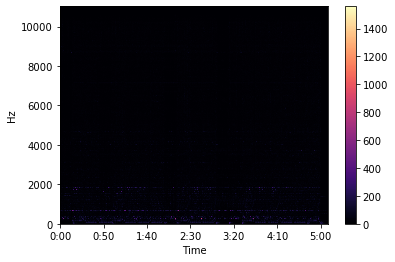

In [5]:
# You won't see much and this cell takes a long time to run so you don't need to run this if you don't want to

librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

In [6]:
# https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies

# only keep the frequencies of the song which are playable on the piano

index_to_freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
for i, f in enumerate(index_to_freq):
    if f > (25.96+27.5)/2: # averaged A0 with midi note below
        lowest_i = i
        break
for i in range(len(index_to_freq)):
    if index_to_freq[i+1] > (4186.01+4434.92)/2: # averaged C8 with C#8
        highest_i = i
        break
piano_D = D[lowest_i:highest_i+1, :]
print(piano_D.shape)

(3183, 13272)


In [7]:
# keep top 25% of sounds - this tries to cut out a lot of the excessive noise

threshold = 0.25

for i in range(piano_D.shape[1]):
    time_slice = piano_D[:,i]
    time_thresh = (1-threshold)*time_slice.max()
    time_slice[time_slice < time_thresh] = 0

# piano_D[piano_D < (piano_D.max()*(1-threshold))] = 0
# super_threshold_indices = piano_D > (piano_D.max()*(1-threshold))
# piano_D[super_threshold_indices] = 0

# each frequency in the list below corresponds to a note on the piano with the addition of the very first and very last frequencies
# for reference, a piano has 88 keys

piano_notes_to_freq = [25.96, 27.5, 29.14, 30.87, 32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49, 51.91, 55,
                       58.27, 61.74, 65.41, 69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54,
                       123.47, 130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185, 196, 207.65, 220, 233.08,
                       246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.3, 440, 466.16,
                       493.88, 523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880, 932.33,
                      987.77, 1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760,
                      1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96,
                      3322.44, 3520, 3729.31, 3951.07, 4186.01, 4434.92]
print(len(piano_notes_to_freq)) # 90 because one midi note below and one midi note above is included

90


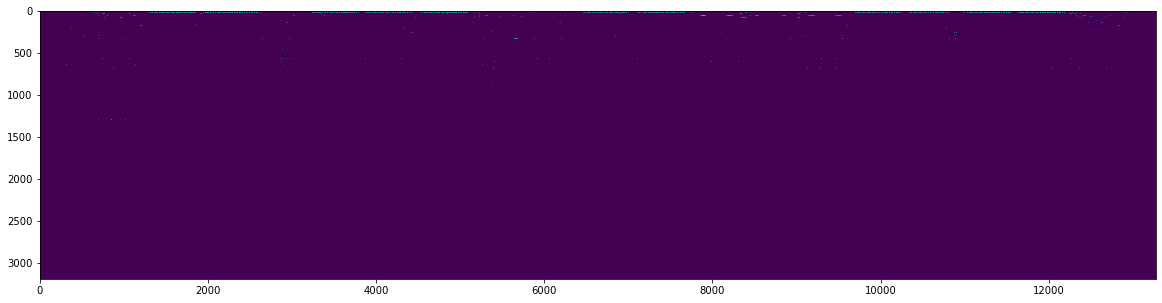

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(piano_D)

In [9]:
print(piano_D.max())

1559.6315


In [10]:
piano_note_bounds = []
for i in range(len(piano_notes_to_freq)-1):
    piano_note_bounds.append((piano_notes_to_freq[i]+piano_notes_to_freq[i+1])/2)
print(len(piano_note_bounds))

89


In [11]:
# convert piano_note_bounds to our current indexes being used in piano_D
lower_index_bounds = []
for b in piano_note_bounds:
    for i in range(piano_D.shape[0]):
        if index_to_freq[lowest_i+i] > b:
            lower_index_bounds.append(i)
            break
print(len(lower_index_bounds))
print(lower_index_bounds)

88
[0, 2, 3, 4, 6, 7, 9, 10, 12, 14, 16, 18, 20, 23, 25, 28, 31, 34, 37, 40, 44, 47, 51, 55, 60, 65, 70, 75, 81, 87, 93, 100, 107, 114, 122, 130, 139, 149, 159, 169, 181, 193, 205, 219, 233, 248, 264, 280, 298, 317, 337, 358, 381, 405, 430, 457, 485, 515, 547, 580, 616, 654, 694, 736, 781, 829, 879, 933, 989, 1049, 1113, 1180, 1252, 1327, 1407, 1492, 1582, 1677, 1778, 1885, 1998, 2118, 2245, 2380, 2523, 2674, 2834, 3004]


In [12]:
print(index_to_freq[lowest_i])
print(index_to_freq[lowest_i-1])
print(index_to_freq[lowest_i+1])

26.91650390625
25.5706787109375
28.2623291015625


In [13]:
print(sr)

22050


In [14]:
# convert all of the frequencies we kept from the song to a piano roll, to be converted to a midi file later

import pretty_midi

new_piano_roll = np.ndarray((128, piano_D.shape[1]))

for i in range(piano_D.shape[1]):
    time_slice = piano_D[:, i]
    for j in range(len(lower_index_bounds)-1):
        midi = j+21 # try flipping: 127-(j+21)
        new_piano_roll[midi, i] = time_slice[lower_index_bounds[j]:lower_index_bounds[j+1]].max()
#         print(time_slice[lower_index_bounds[j]:lower_index_bounds[j+1]])
#         print(time_slice[lower_index_bounds[j]:lower_index_bounds[j+1]].max())
    new_piano_roll[midi+1, i] = time_slice[lower_index_bounds[-1]:].max()

new_piano_roll = new_piano_roll/new_piano_roll.max()*100

In [15]:
print(new_piano_roll.max())

100.0


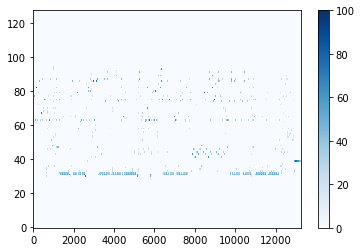

In [16]:
# plot piano roll as heat map
# this is almsot like looking at a piano score - each blue dot is a note on the piano being played

plt.imshow(new_piano_roll, cmap="Blues", aspect="auto", origin=[128,0]) # auto makes each box rectangular, origin puts 128th row on top
plt.colorbar()
plt.show()

In [17]:
# convert piano roll to PrettyMIDI object
# NOTE: Code below is copied directly from: https://github.com/craffel/pretty-midi/blob/master/examples/reverse_pianoroll.py
# In accordance with their citation policy:
# Colin Raffel and Daniel P. W. Ellis. Intuitive Analysis, Creation and Manipulation of MIDI Data with pretty_midi. In Proceedings of the 15th International Conference on Music Information Retrieval Late Breaking and Demo Papers, 2014.

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

song_pretty_midi = piano_roll_to_pretty_midi(new_piano_roll, fs=50)

In [21]:
# export new song as a midi file

song_pretty_midi.write(r"C:\Song.mid")